<a href="https://colab.research.google.com/github/LucasO21/ml-with-python/blob/main/ames-housing-prediction/aimes_prediction_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook Settings

In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
# set working directory
import os

cwd = '/content/gdrive/MyDrive/ml-with-python/aimes_analysis'
os.chdir(cwd)

## Package Imports

In [3]:
# installs
! pip install feature_engine &> /dev/null

In [4]:
# imports

# core 
import pandas as pd
import numpy as np
import pickle
pd.set_option('display.max_columns', 100)

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import set_config
set_config(display="diagram")

# data preprocessing
from sklearn.model_selection import train_test_split
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import RareLabelEncoder,OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display="diagram")

# stats
from scipy import stats

# modeling
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error


## Load Data

In [6]:
# load data
df_full = pd.read_csv('data/ames_training_data.csv')
df_full.shape

(2197, 82)

In [7]:
# view head
df_full.head()

,order,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,sale_condition,saleprice
0,534,531363010,20,RL,80.0,9605,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,SawyerW,Norm,Norm,1Fam,1Story,7,6,2007,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,1218.0,1218.0,GasA,Ex,Y,SBrkr,1218,0,0,1218,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Detchd,2007.0,RFn,2.0,576.0,TA,TA,Y,0,178,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,Normal,159000
1,803,906203120,20,RL,90.0,14684,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,1Story,7,7,1990,1991,Hip,CompShg,HdBoard,HdBoard,BrkFace,234.0,Gd,TA,CBlock,Gd,TA,Mn,ALQ,485.0,BLQ,177.0,1496.0,2158.0,GasA,Gd,Y,SBrkr,2196,0,0,2196,0.0,0.0,2,0,3,1,Gd,7,Typ,1,TA,Attchd,1990.0,RFn,3.0,701.0,TA,TA,Y,84,70,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal,271900
2,956,916176030,20,RL,NaN,14375,Pave,NaN,IR1,Lvl,NoSeWa,CulDSac,Gtl,Timber,Norm,Norm,1Fam,SLvl,6,6,1958,1958,Gable,CompShg,HdBoard,HdBoard,BrkFace,541.0,TA,TA,CBlock,TA,TA,No,GLQ,111.0,Rec,354.0,354.0,819.0,GasA,Gd,Y,FuseA,1344,0,0,1344,0.0,1.0,1,0,3,1,Gd,7,Typ,1,Gd,Basment,1958.0,RFn,2.0,525.0,TA,TA,Y,0,118,0,0,233,0,NaN,NaN,NaN,0,1,2009,COD,Abnorml,137500
3,460,528180130,120,RL,48.0,6472,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,TwnhsE,1Story,9,5,2008,2008,Hip,CompShg,VinylSd,VinylSd,BrkFace,500.0,Ex,TA,PConc,Ex,TA,No,Unf,0.0,Unf,0.0,1451.0,1451.0,GasA,Ex,Y,SBrkr,1456,0,0,1456,0.0,0.0,2,0,2,1,Ex,6,Typ,1,Gd,Attchd,2008.0,RFn,2.0,539.0,TA,TA,Y,192,42,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,Normal,248500
4,487,528290030,80,RL,61.0,9734,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,RRAn,Norm,1Fam,SLvl,7,5,2004,2004,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,241.0,Rec,113.0,30.0,384.0,GasA,Ex,Y,SBrkr,744,630,0,1374,0.0,0.0,2,1,3,1,Gd,7,Typ,0,NaN,BuiltIn,2004.0,Fin,2.0,400.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal,167000


In [10]:
# filter for best features (determined in feature engineering notebook)
df = df_full[['ms_zoning', 'lot_frontage', 'lot_area', 'land_slope', 'neighborhood',
       'overall_qual', 'year_built', 'year_remod/add', 'roof_matl',
       'exterior_1st', 'mas_vnr_area', 'exter_qual', 'bsmt_qual',
       'bsmt_exposure', 'bsmtfin_sf_1', 'bsmt_unf_sf', 'total_bsmt_sf',
       'central_air', '2nd_flr_sf', 'gr_liv_area', 'bsmt_full_bath',
       'full_bath', 'bedroom_abvgr', 'kitchen_qual', 'fireplaces',
       'garage_type', 'garage_finish', 'garage_cars', 'wood_deck_sf',
       'open_porch_sf', 'screen_porch', 'mo_sold', 'yr_sold', 
       '1st_flr_sf', 'bsmt_half_bath', 'half_bath', 'kitchen_abvgr', 'totrms_abvgrd', 'saleprice']]

df.shape

(2197, 39)

In [11]:
# view head
df.head()


,ms_zoning,lot_frontage,lot_area,land_slope,neighborhood,overall_qual,year_built,year_remod/add,roof_matl,exterior_1st,mas_vnr_area,exter_qual,bsmt_qual,bsmt_exposure,bsmtfin_sf_1,bsmt_unf_sf,total_bsmt_sf,central_air,2nd_flr_sf,gr_liv_area,bsmt_full_bath,full_bath,bedroom_abvgr,kitchen_qual,fireplaces,garage_type,garage_finish,garage_cars,wood_deck_sf,open_porch_sf,screen_porch,mo_sold,yr_sold,1st_flr_sf,bsmt_half_bath,half_bath,kitchen_abvgr,totrms_abvgrd,saleprice
0,RL,80.0,9605,Gtl,SawyerW,7,2007,2007,CompShg,VinylSd,0.0,Gd,Gd,No,0.0,1218.0,1218.0,Y,0,1218,0.0,1,3,Gd,0,Detchd,RFn,2.0,0,178,0,4,2009,1218,0.0,1,1,6,159000
1,RL,90.0,14684,Gtl,SawyerW,7,1990,1991,CompShg,HdBoard,234.0,Gd,Gd,Mn,485.0,1496.0,2158.0,Y,0,2196,0.0,2,3,Gd,1,Attchd,RFn,3.0,84,70,0,6,2009,2196,0.0,0,1,7,271900
2,RL,NaN,14375,Gtl,Timber,6,1958,1958,CompShg,HdBoard,541.0,TA,TA,No,111.0,354.0,819.0,Y,0,1344,0.0,1,3,Gd,1,Basment,RFn,2.0,0,118,233,1,2009,1344,1.0,0,1,7,137500
3,RL,48.0,6472,Gtl,NridgHt,9,2008,2008,CompShg,VinylSd,500.0,Ex,Ex,No,0.0,1451.0,1451.0,Y,0,1456,0.0,2,2,Ex,1,Attchd,RFn,2.0,192,42,0,4,2009,1456,0.0,0,1,6,248500
4,RL,61.0,9734,Gtl,Gilbert,7,2004,2004,CompShg,VinylSd,0.0,Gd,Gd,Mn,241.0,30.0,384.0,Y,630,1374,0.0,2,3,Gd,0,BuiltIn,Fin,2.0,0,0,0,5,2009,744,0.0,1,1,7,167000


In [12]:
# info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2197 entries, 0 to 2196
Data columns (total 39 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ms_zoning       2197 non-null   object 
 1   lot_frontage    1835 non-null   float64
 2   lot_area        2197 non-null   int64  
 3   land_slope      2197 non-null   object 
 4   neighborhood    2197 non-null   object 
 5   overall_qual    2197 non-null   int64  
 6   year_built      2197 non-null   int64  
 7   year_remod/add  2197 non-null   int64  
 8   roof_matl       2197 non-null   object 
 9   exterior_1st    2197 non-null   object 
 10  mas_vnr_area    2175 non-null   float64
 11  exter_qual      2197 non-null   object 
 12  bsmt_qual       2130 non-null   object 
 13  bsmt_exposure   2128 non-null   object 
 14  bsmtfin_sf_1    2196 non-null   float64
 15  bsmt_unf_sf     2196 non-null   float64
 16  total_bsmt_sf   2196 non-null   float64
 17  central_air     2197 non-null   o

In [13]:
# check for nulls
df.isnull().sum()/len(df)

ms_zoning         0.000000
lot_frontage      0.164770
lot_area          0.000000
land_slope        0.000000
neighborhood      0.000000
overall_qual      0.000000
year_built        0.000000
year_remod/add    0.000000
roof_matl         0.000000
exterior_1st      0.000000
mas_vnr_area      0.010014
exter_qual        0.000000
bsmt_qual         0.030496
bsmt_exposure     0.031406
bsmtfin_sf_1      0.000455
bsmt_unf_sf       0.000455
total_bsmt_sf     0.000455
central_air       0.000000
2nd_flr_sf        0.000000
gr_liv_area       0.000000
bsmt_full_bath    0.000455
full_bath         0.000000
bedroom_abvgr     0.000000
kitchen_qual      0.000000
fireplaces        0.000000
garage_type       0.054620
garage_finish     0.055530
garage_cars       0.000455
wood_deck_sf      0.000000
open_porch_sf     0.000000
screen_porch      0.000000
mo_sold           0.000000
yr_sold           0.000000
1st_flr_sf        0.000000
bsmt_half_bath    0.000455
half_bath         0.000000
kitchen_abvgr     0.000000
t

__Observation:__ Several features have null values. We'll need to come up with an imputation strategy for these null values.

## Exploratory Data Analysis

### Numeric Features

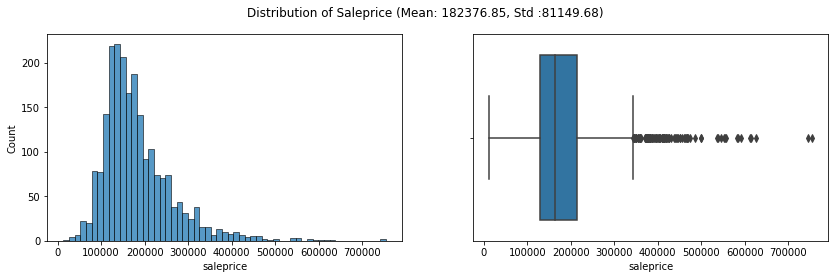

In [15]:
# distribution of saleprice
mu_saleprice = round(np.mean(df['saleprice']), 2)
sigma_saleprice = round(np.std(df['saleprice']), 2)

fig, axes = plt.subplots(1, 2, figsize=(14, 3.8), sharey=False)
fig.suptitle('Distribution of Saleprice (Mean: {}, Std :{})'.format(mu_saleprice, sigma_saleprice));
sns.histplot(x='saleprice', data=df, ax=axes[0]);
sns.boxplot(x='saleprice', data=df, ax=axes[1]);

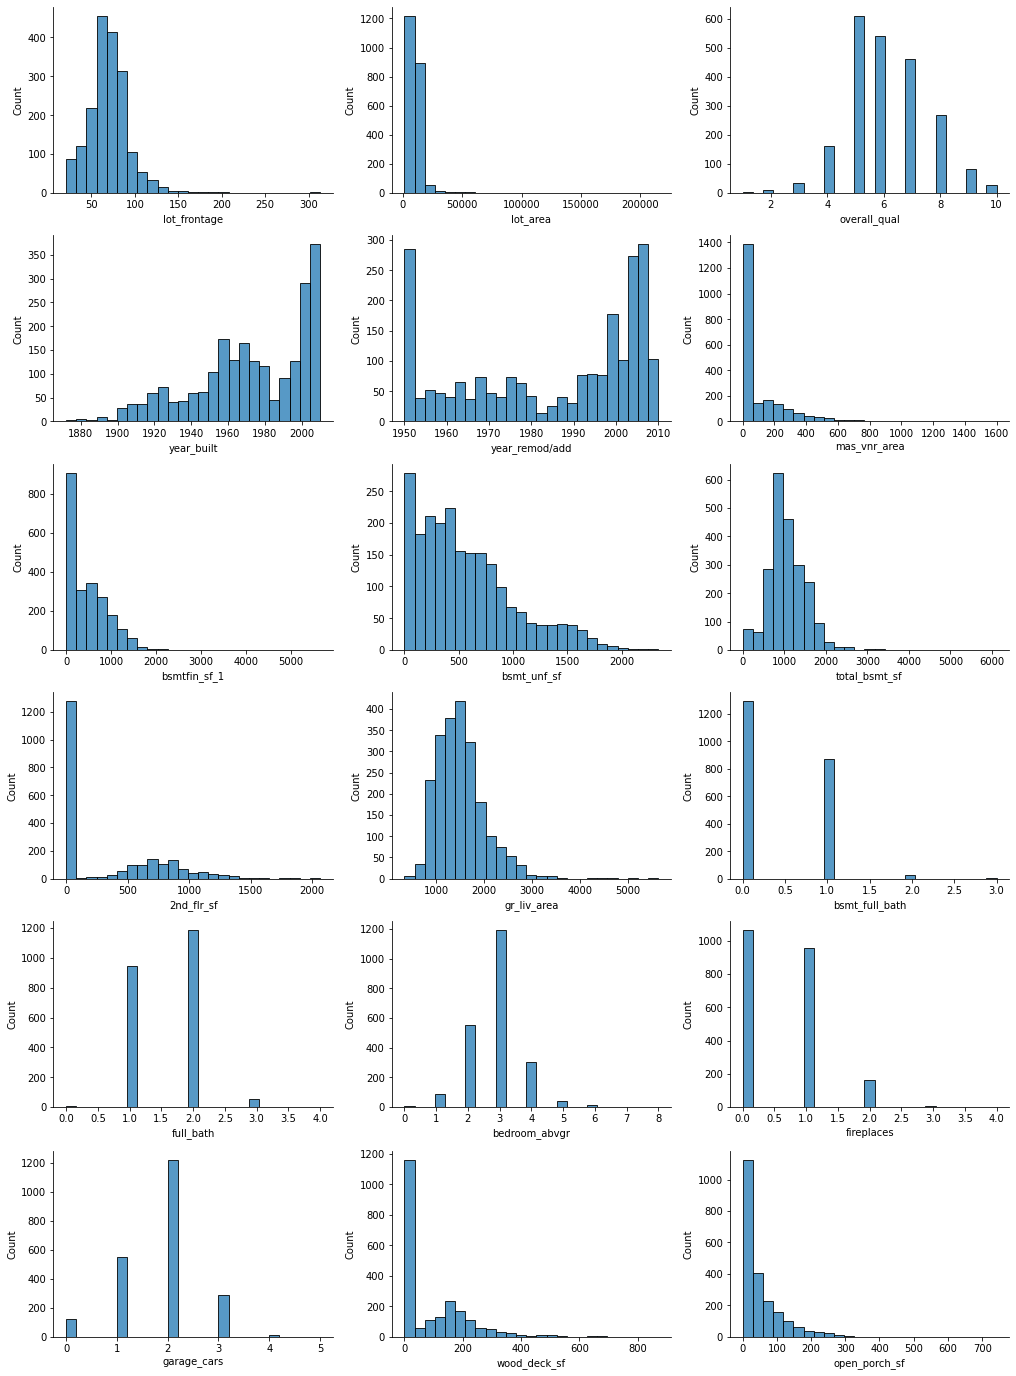

In [16]:
# distribution of numeric features
num_features = df.select_dtypes(exclude='object').drop('saleprice', axis=1).columns.tolist()

fig, axes = plt.subplots(6, 3, figsize=(14, 19), constrained_layout=True)

for feature, ax in zip(num_features, axes.ravel()):
    sns.histplot(x=feature, data=df, ax=ax, bins=25)
    sns.despine()

__Observation:__ Several numeric features appear skewed. We'll need a strategy for feature transformation later on.

### Categorical Features

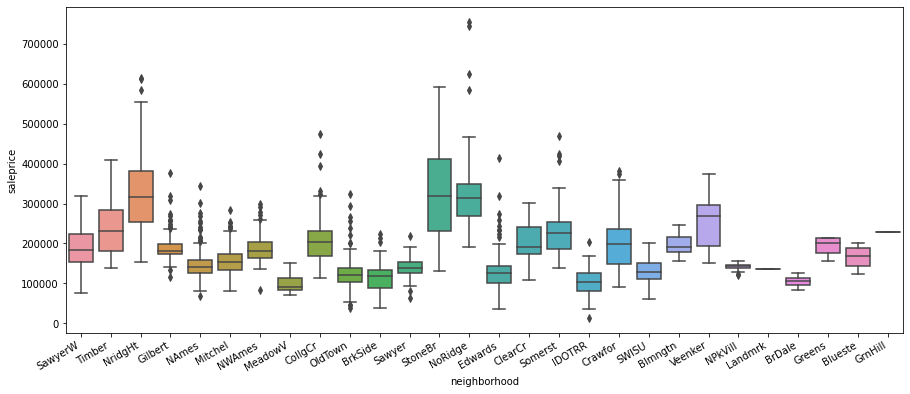

In [17]:
# distribution of saleprice by neighborhood
plt.figure(figsize = (15, 6))
ax = sns.boxplot(x='neighborhood', y='saleprice', data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30, horizontalalignment='right');

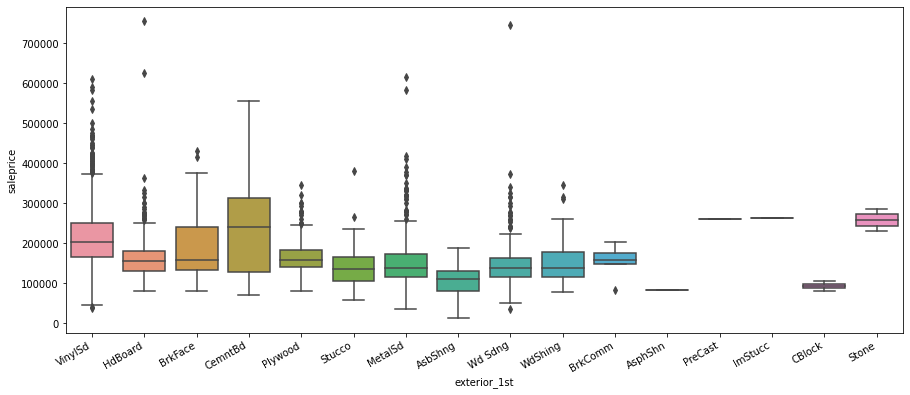

In [18]:
# distribution of saleprice by exterior 1st
plt.figure(figsize = (15, 6))
ax = sns.boxplot(x='exterior_1st', y='saleprice', data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30, horizontalalignment='right');

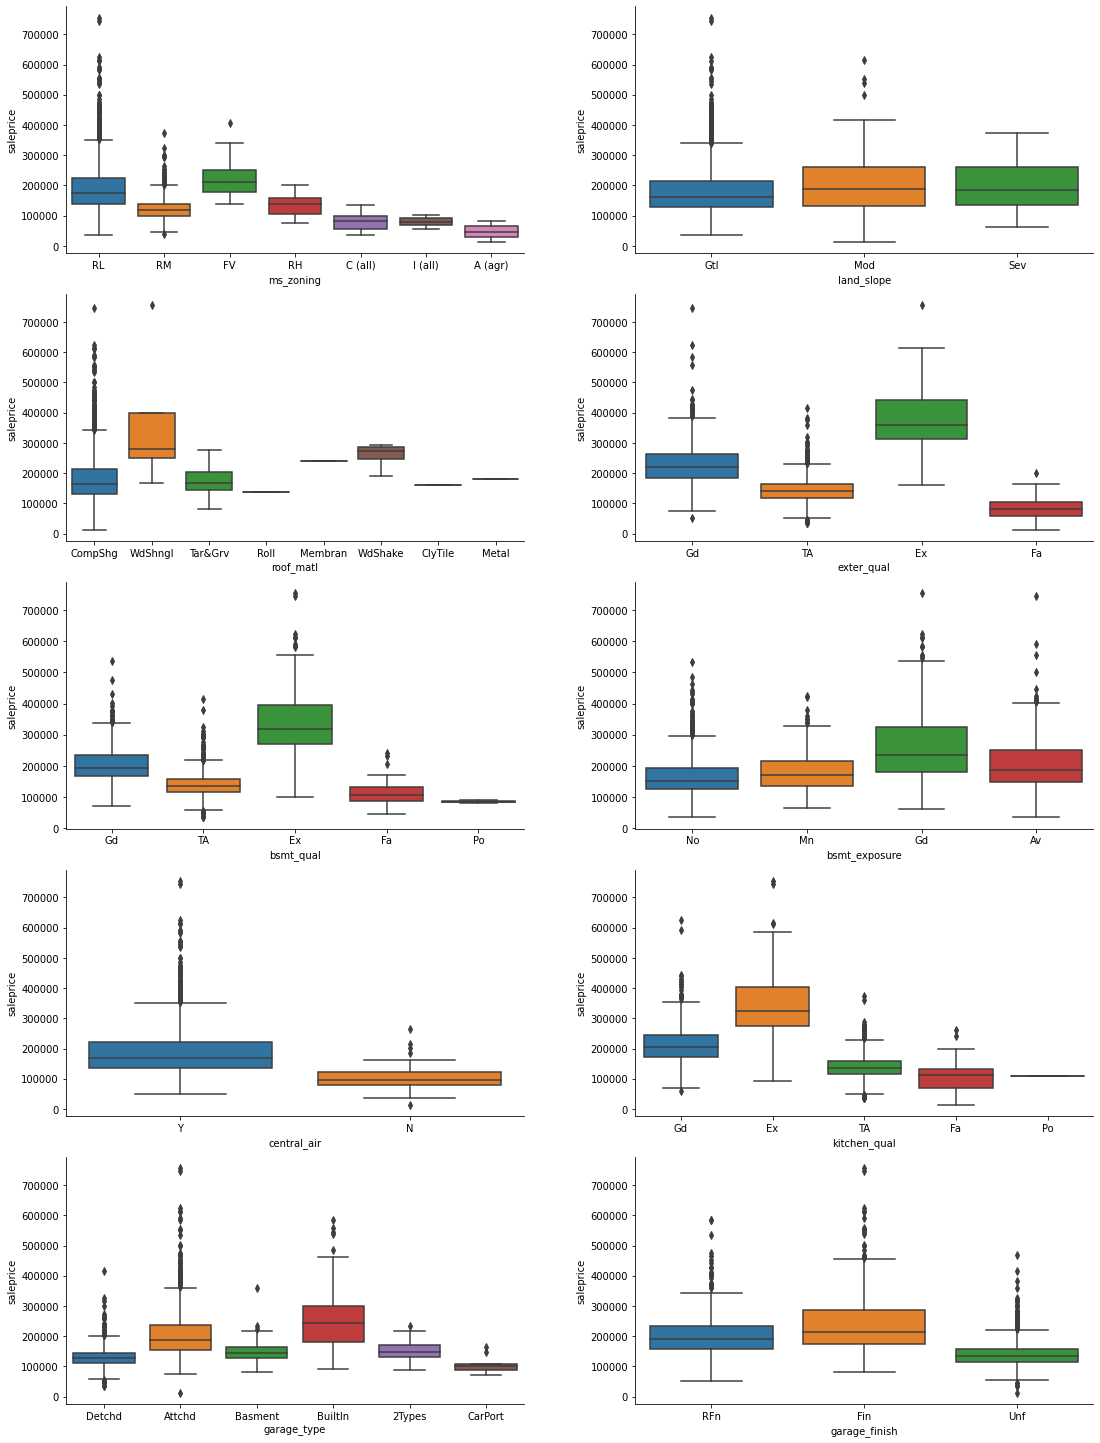

In [19]:
# distribution sale price by other categorical featues
cat_features = df.select_dtypes(include='object').drop(['neighborhood', 'exterior_1st'], axis=1).columns.tolist()

fig, axes = plt.subplots(5, 2, figsize=(15, 20))
fig.tight_layout(pad=1.08, w_pad=8, h_pad=2)

for feature, ax in zip(cat_features, axes.ravel()):
    sns.boxplot(x=feature, y='saleprice', data=df, ax=ax)
    sns.despine()    

### Correlation (Numeric Features)

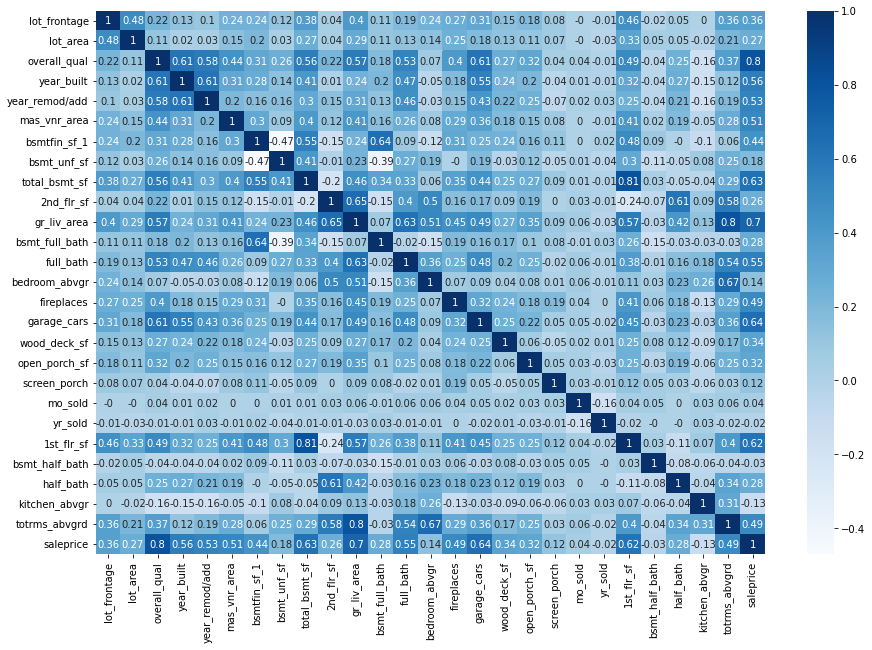

In [20]:
# correlation heatmap
plt.figure(figsize = (15, 10))
sns.heatmap(data = round(df.select_dtypes(exclude='object').corr(), 2), cmap='Blues', annot=True);

### Scatterplots

In [21]:
# scatterplot function
def get_scatter_plot(data, x, y, ax):
    corr = round(data[x].corr(data[y]), 2)
    ax = sns.scatterplot(x=x, y=y, data=data, ax=ax)
    ax.set_title(f'{x} vs {y} - correlation: ' + str(corr))

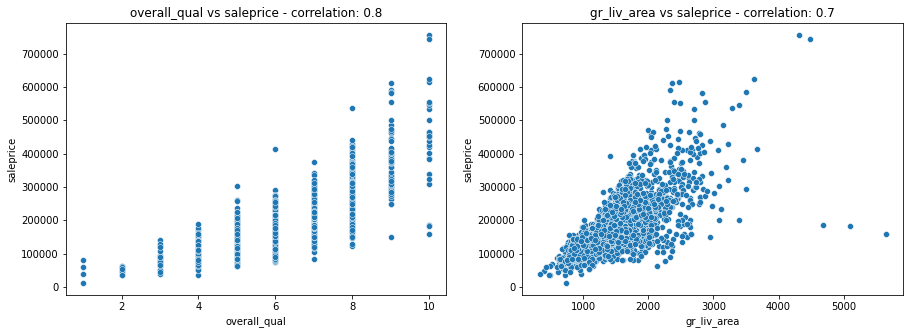

In [22]:
# distribution of saleprice
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
get_scatter_plot(x='overall_qual', y='saleprice', data=df, ax=axes[0]);
get_scatter_plot(x='gr_liv_area', y='saleprice', data=df, ax=axes[1]);

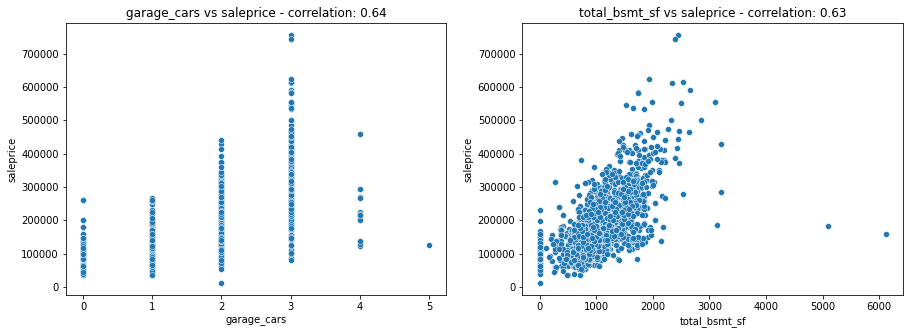

In [23]:
# distribution of saleprice
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
get_scatter_plot(x='garage_cars', y='saleprice', data=df, ax=axes[0]);
get_scatter_plot(x='total_bsmt_sf', y='saleprice', data=df, ax=axes[1]);

## Feature Engineering

In [25]:
# create new featues
df_feat_eng = df\
    .assign(age_at_sold = lambda x: x['yr_sold'] - x['year_built'])\
    .assign(abvgr_sf = lambda x: x['2nd_flr_sf'] + x['1st_flr_sf'])\
    .assign(total_sf = lambda x: x['abvgr_sf'] + x['total_bsmt_sf'])\
    .assign(abvgr_full_bath_per_room = lambda x: x['full_bath'] / x['totrms_abvgrd']) 

df_feat_eng.shape

(2197, 43)

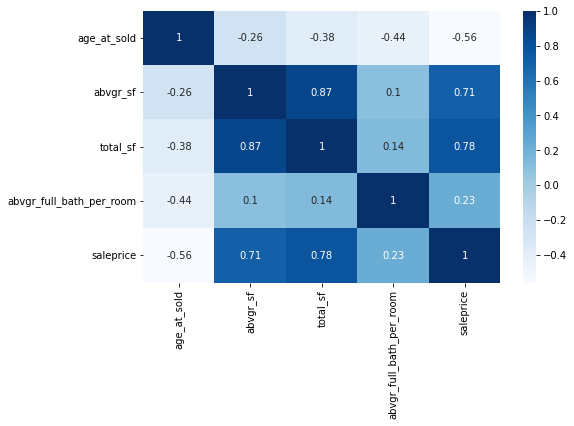

In [26]:
# check correlation of new features
plt.figure(figsize = (8, 5))
sns.heatmap( 
    data=round(df_feat_eng[['age_at_sold', 'abvgr_sf', 'total_sf', 'abvgr_full_bath_per_room', 'saleprice']].corr(), 2),
    cmap='Blues', 
    annot=True
);

__Observation:__ The new features show high correlation with *saleprice*.

## Data Preprocessing

### Train Test Split

In [27]:
# get x and y features
X = df_feat_eng.drop('saleprice', axis=1)
y = df_feat_eng['saleprice']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((1757, 42), (440, 42))

### Transformation Pipelines


In [28]:
# get feature names
num_feature_names = X_train.select_dtypes(exclude='object').columns.tolist()
cat_feature_names = X_train.select_dtypes(include='object').columns.tolist()

In [29]:
# get numeric and categorical dataframes
num_df = X_train.select_dtypes(exclude='object')
cat_df = X_train.select_dtypes(include='object')

num_df.shape, cat_df.shape

((1757, 30), (1757, 12))

In [30]:
# pipelines

# numeric pipeline
num_pipe = Pipeline([
    ('num_imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

# categorical pipeline
cat_pipe = Pipeline([
    ('cat_imputer', CategoricalImputer(imputation_method='frequent')),
    ('rare_label_enc', RareLabelEncoder(tol=0.05, n_categories=4)),
    ('ohe_enc', OneHotEncoder(handle_unknown='ignore'))
])

# full transformation pipeline
full_pipe = ColumnTransformer([
    ('num', num_pipe, num_feature_names),
    ('cat', cat_pipe, cat_feature_names),
])

full_pipe

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['lot_frontage', 'lot_area', 'overall_qual',
                                  'year_built', 'year_remod/add',
                                  'mas_vnr_area', 'bsmtfin_sf_1', 'bsmt_unf_sf',
                                  'total_bsmt_sf', '2nd_flr_sf', 'gr_liv_area',
                                  'bsmt_full_bath', 'full_bath',
                                  'bedroom_abvgr', 'firepla...
                                 Pipeline(steps=[('cat_imputer',
                                                  CategoricalImputer(imputation_method='frequent')),
                                                 ('rare_label_enc',
                                                  RareLabelEncoder(n_categories=4)),
                                                 ('ohe_enc',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['ms_zoning', 'land_slope', 'neighborhood',
                                  'roof_matl', 'exterior_1st', 'exter_qual',
                                  'bsmt_qual', 'bsmt_exposure', 'central_air',
                                  'kitchen_qual', 'garage_type',
                                  'garage_finish'])])

The next cell show hows to extract feature names after applying a transformation pipeline.

In [31]:
# fit full pipeline to train data
full_pipe.fit(X_train)

# transform train and test data
X_train_trans = full_pipe.transform(X_train)
X_test_trans = full_pipe.transform(X_test)

# get transformed feature names
trans_feature_names = num_feature_names + full_pipe.named_transformers_['cat']['ohe_enc'].get_feature_names_out().tolist()
len(trans_feature_names)

/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable land_slope is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable exter_qual is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable bsmt_exposure is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable central_air is

77

## Modeling

### Baseline Model

In [32]:
# function to build random forest model and compare performance in train and test data
def get_baseline_model(estimator, preprocessor, X_train, y_train, X_test, y_test, preproc_method):
    
    # pipeline
    preprocessor.fit(X_train)
    X_train = full_pipe.transform(X_train)
    X_test = full_pipe.transform(X_test)
    
    # train fit with cross validation
    train_score = cross_val_score(estimator, X_train, y_train, cv=5,  scoring='neg_mean_squared_error')
    train_score = np.sqrt(abs(train_score.mean()))
        
    # test fit with cross validation
    test_score = cross_val_score(estimator, X_test, y_test, cv=5, scoring='neg_mean_squared_error')
    test_score = np.sqrt(abs(test_score.mean()))
    
    # performance
    print('Preprocessing Method: ', preproc_method)
    print('------------------------------------------------')
    print('Train Set RMSE: ', train_score)
    print('Test Set: RMSE', test_score) 

In [33]:
# base model - basic preprocessing
get_baseline_model( 
    estimator=RandomForestRegressor(n_estimators=200, max_depth=4, random_state=41),
    preprocessor=full_pipe,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    preproc_method='Basic Preprocessing'
)

/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable land_slope is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable exter_qual is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable bsmt_exposure is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable central_air is

Preprocessing Method:  Basic Preprocessing
------------------------------------------------
Train Set RMSE:  32752.590959512716
Test Set: RMSE 32908.66307617253


### Feature Transformation

Here I explore other transformation methods.

In [34]:
# function to plot distributions and proability plots

def diagnostic_plots(data, feature):
    
    data = data.assign(sale_price=y_train)
    
    plt.figure(figsize=(25, 4))
    y_var = 'sale_price'
               
    plt.subplot(1, 4, 1)
    ax = sns.histplot(data[feature], bins=30);
    ax.set_title('Histogram of {}'.format(feature));
    
    plt.subplot(1, 4, 2)
    stats.probplot(data[feature], dist='norm', plot=plt);
    plt.title('Probability plot of {}'.format(feature))
    plt.ylabel('RM Quantiles');
    
    plt.subplot(1, 4, 3)
    ax = sns.boxplot(x=data[feature]);
    ax.set_title('Boxplot of {}'.format(feature));
    
    plt.subplot(1, 4, 4)
    ax = sns.regplot(x=feature, y='sale_price', data=data);
    ax.set_title('Scatterplot of {} vs {}'.format(feature, y_var));

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `fi

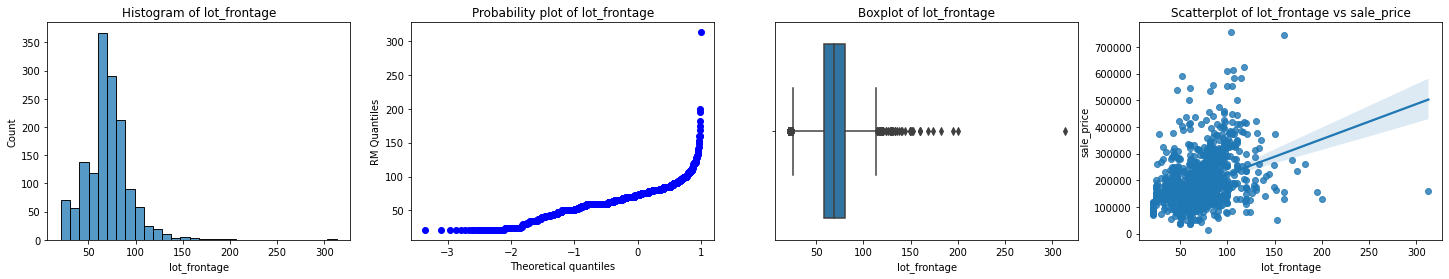

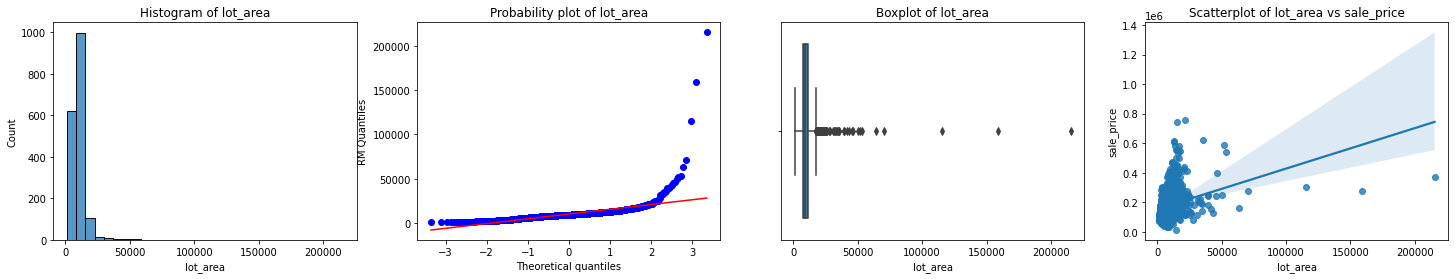

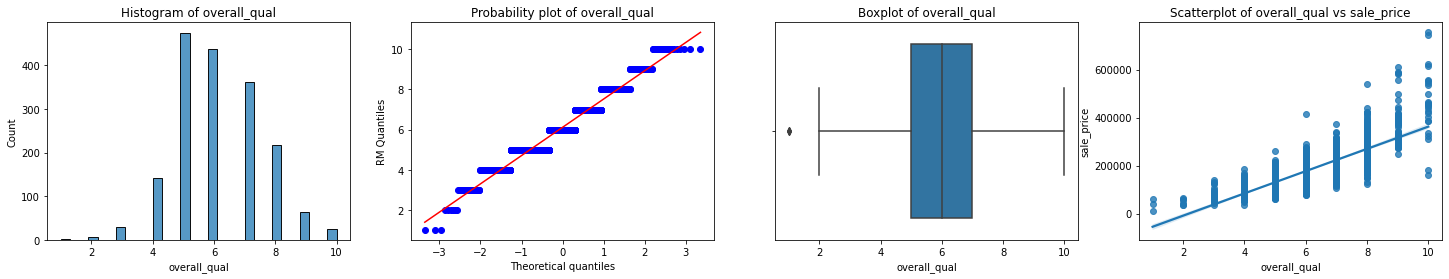

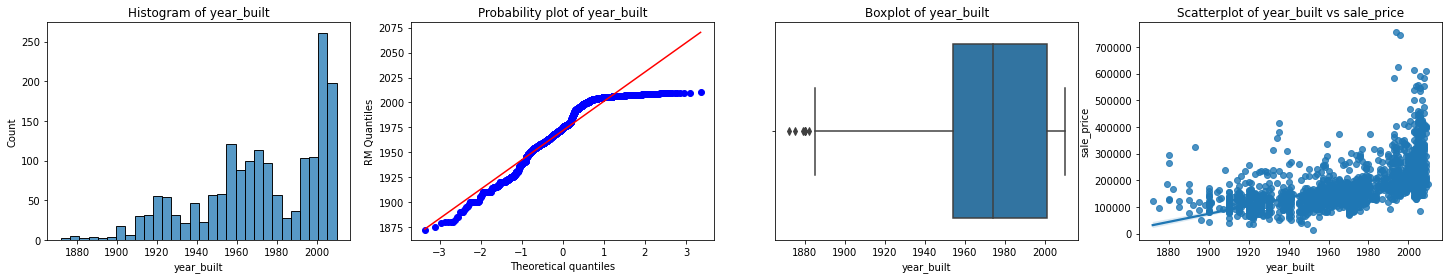

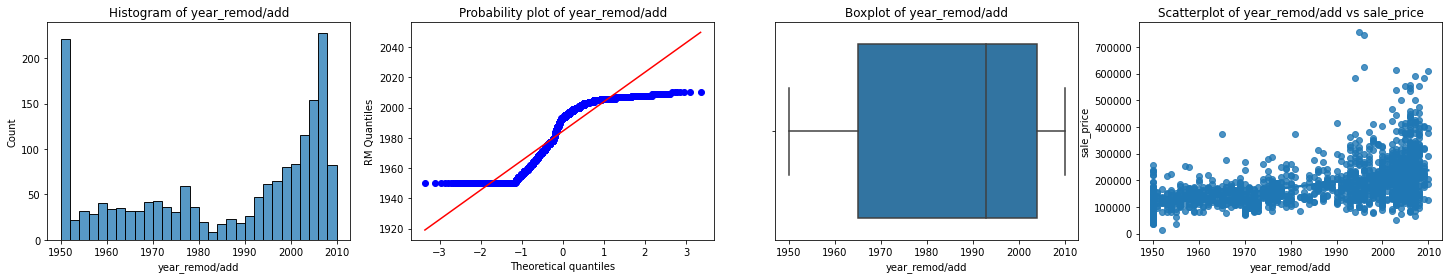

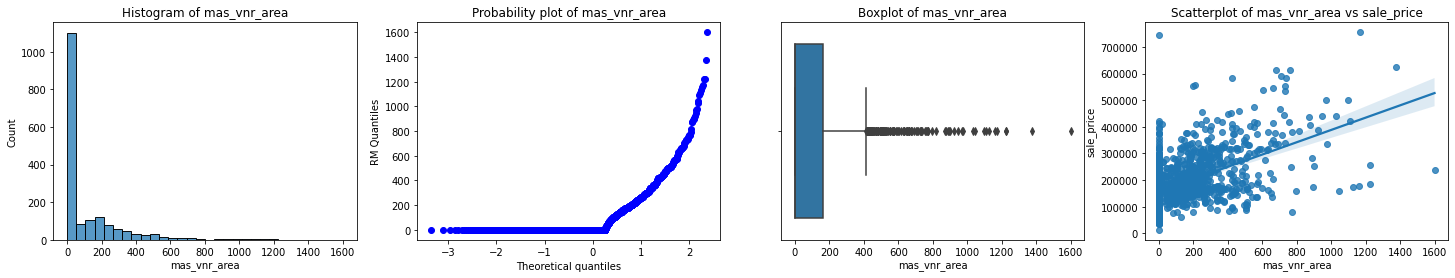

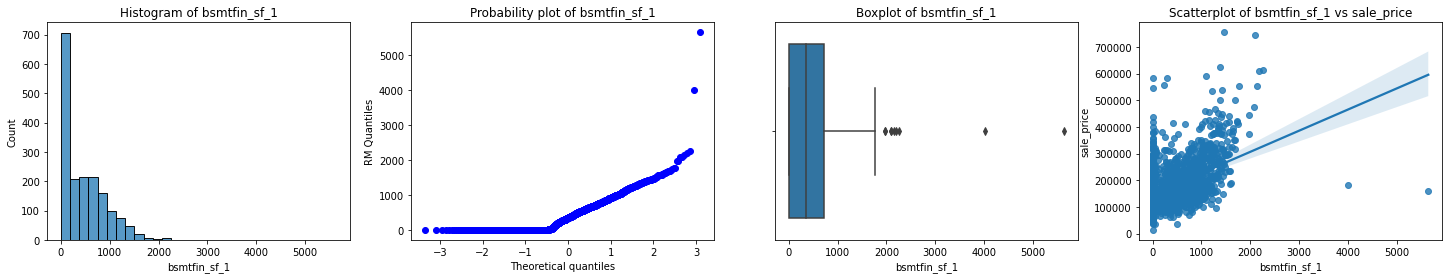

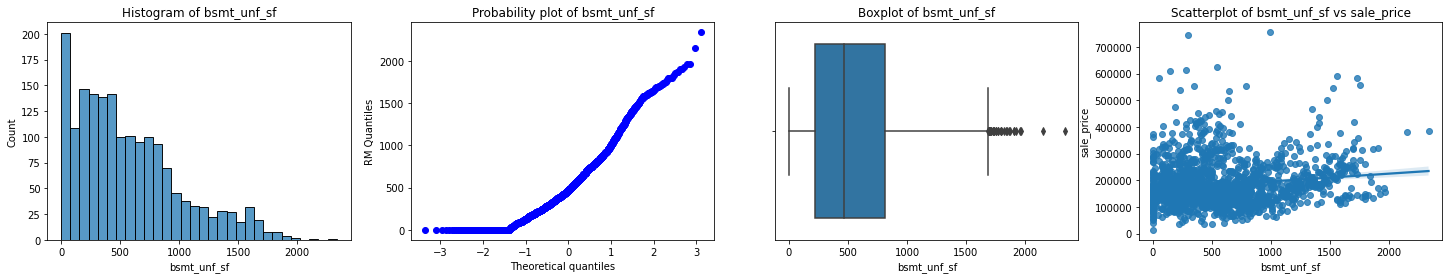

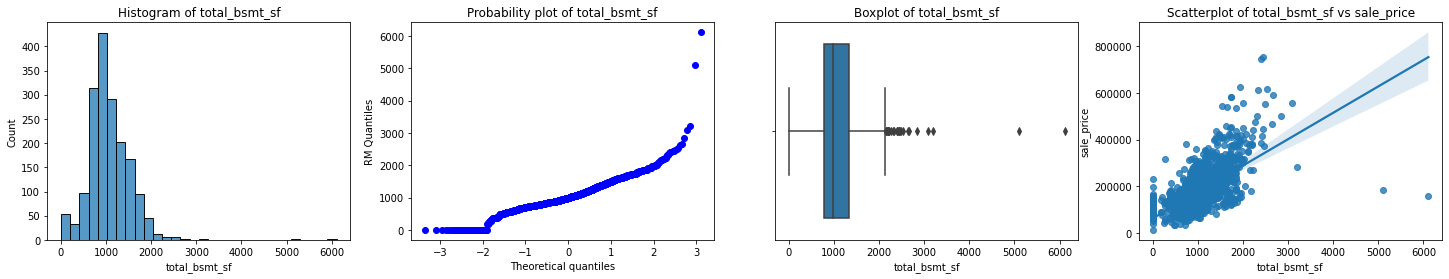

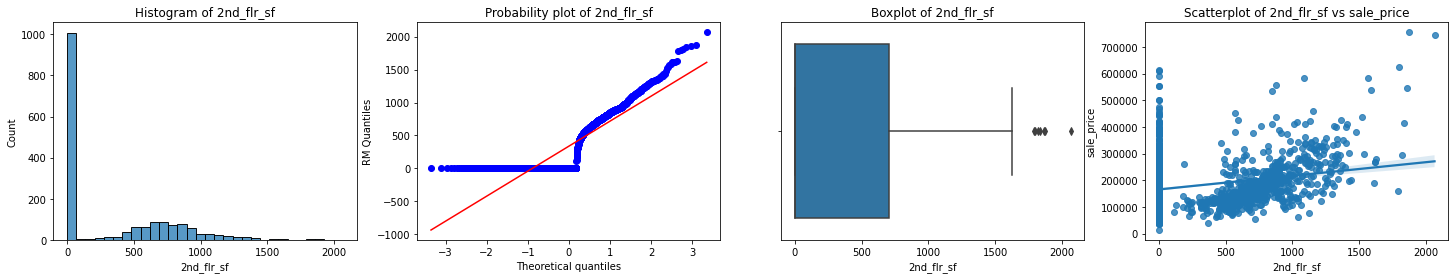

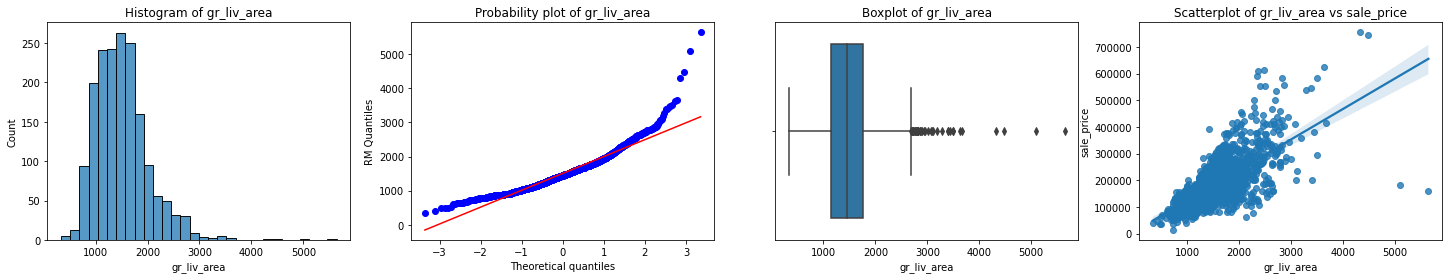

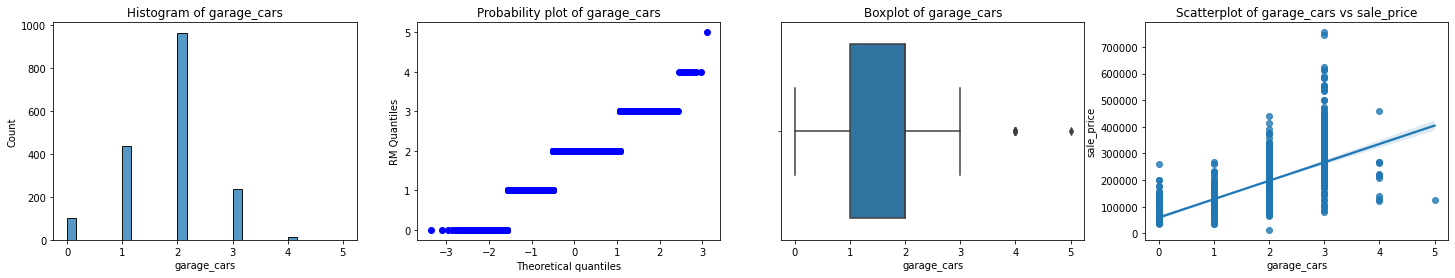

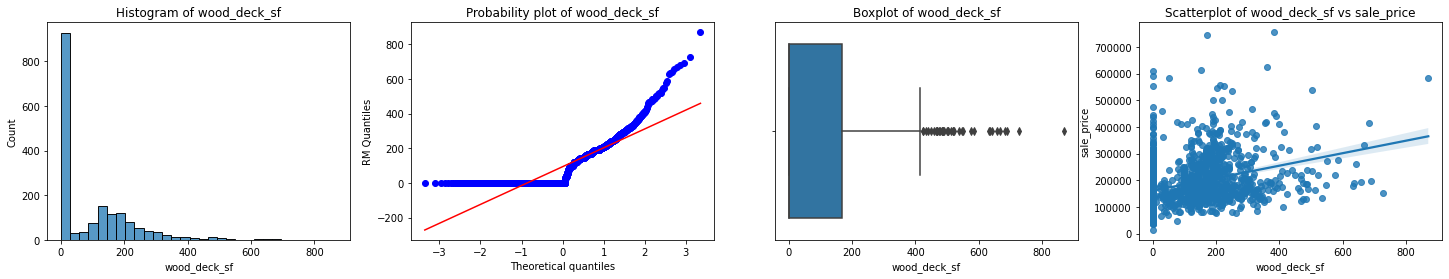

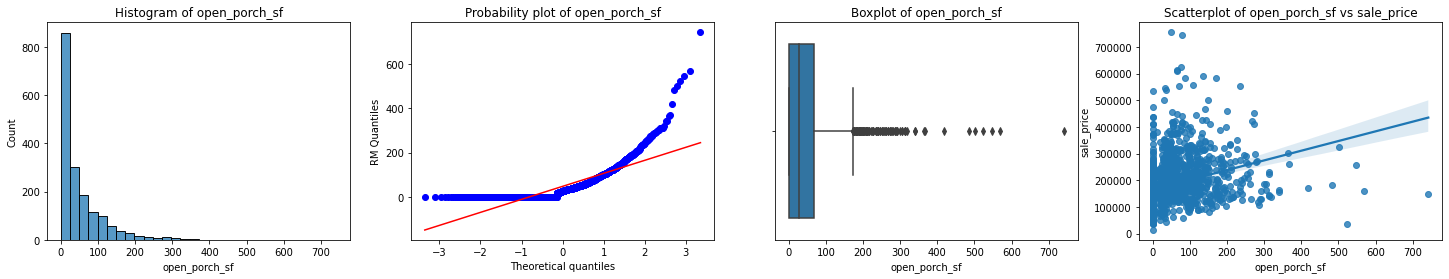

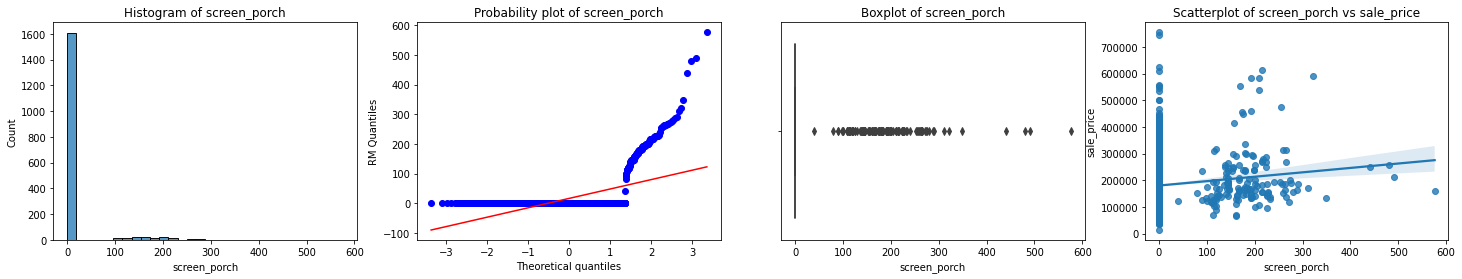

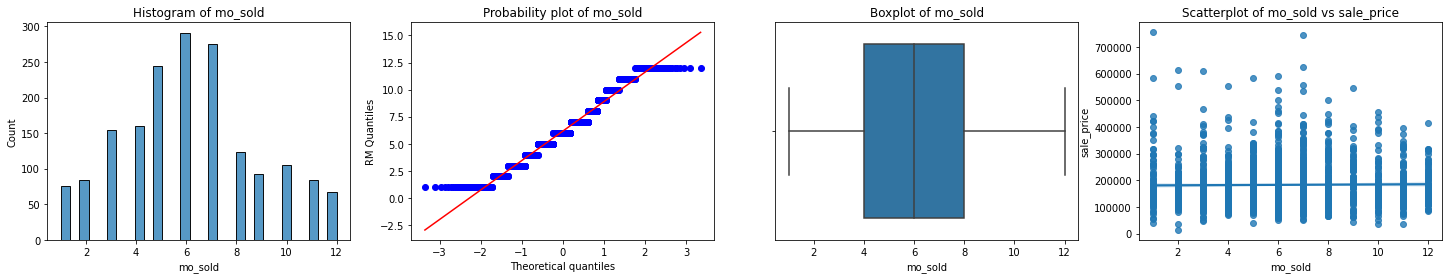

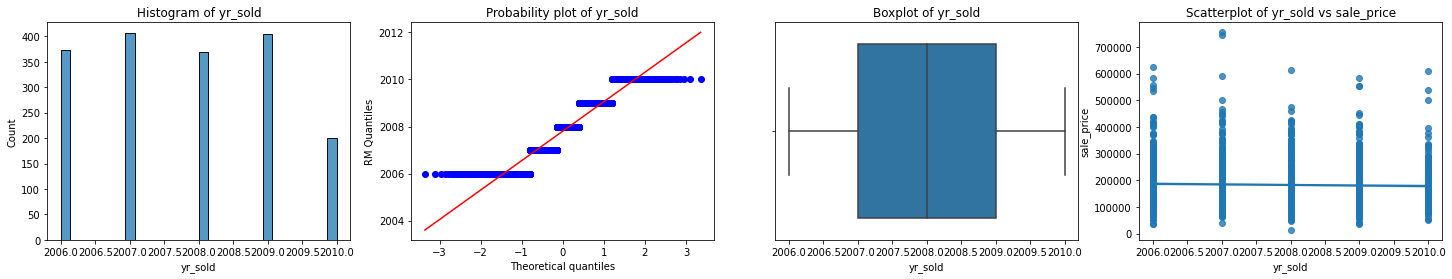

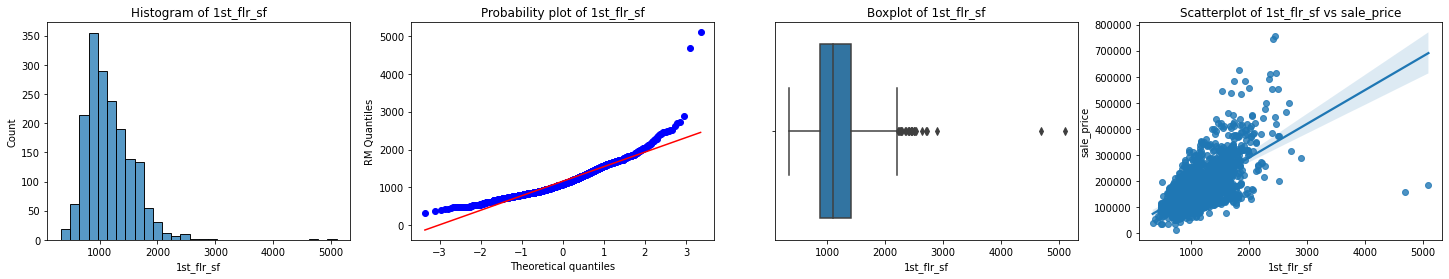

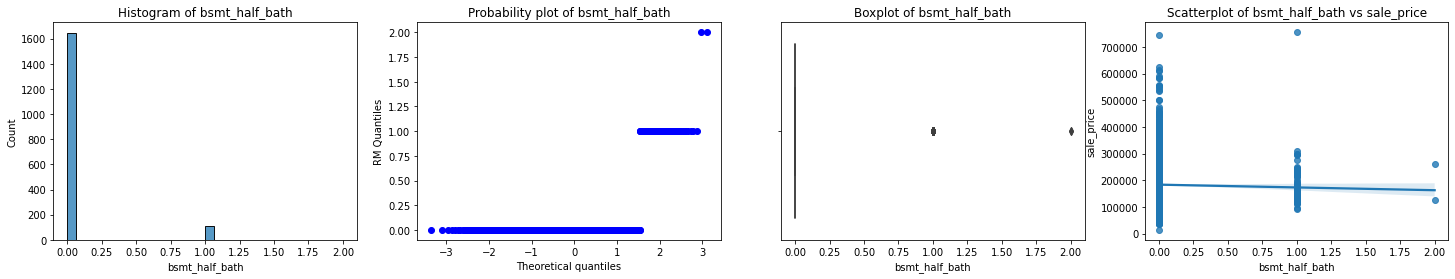

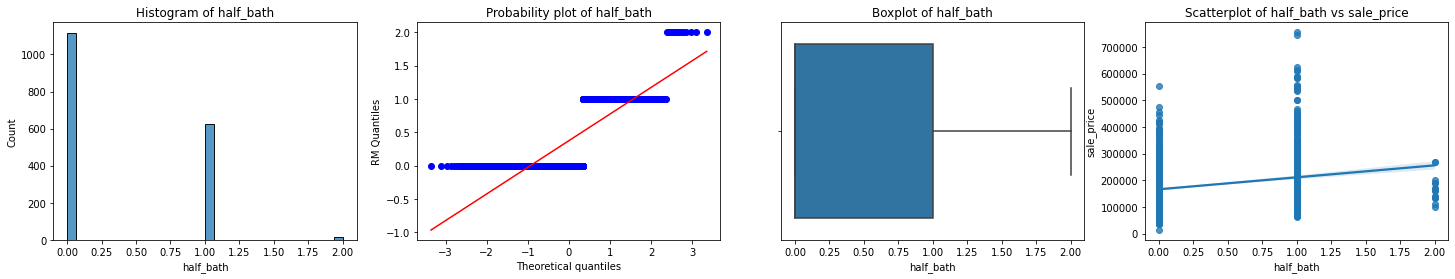

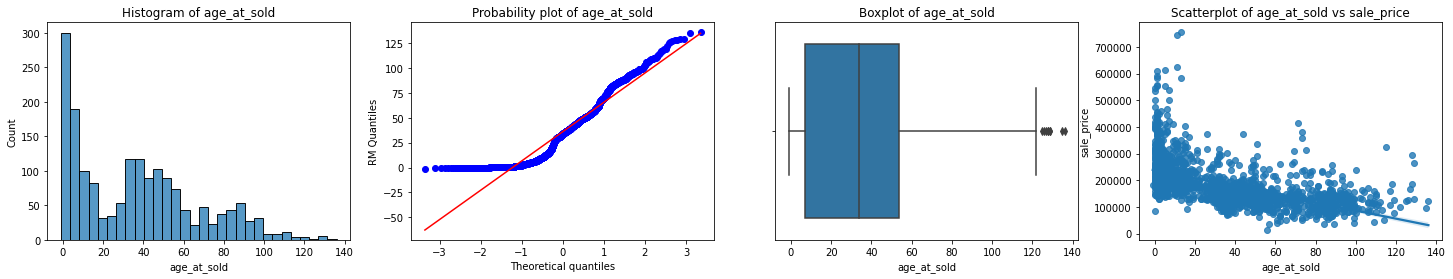

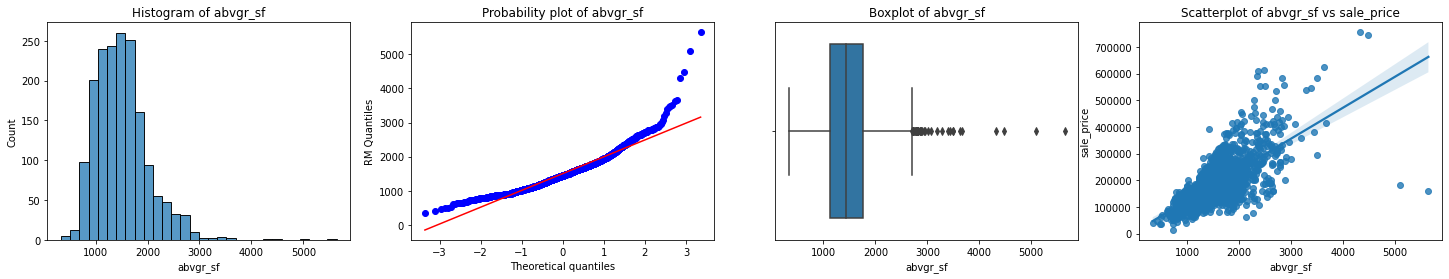

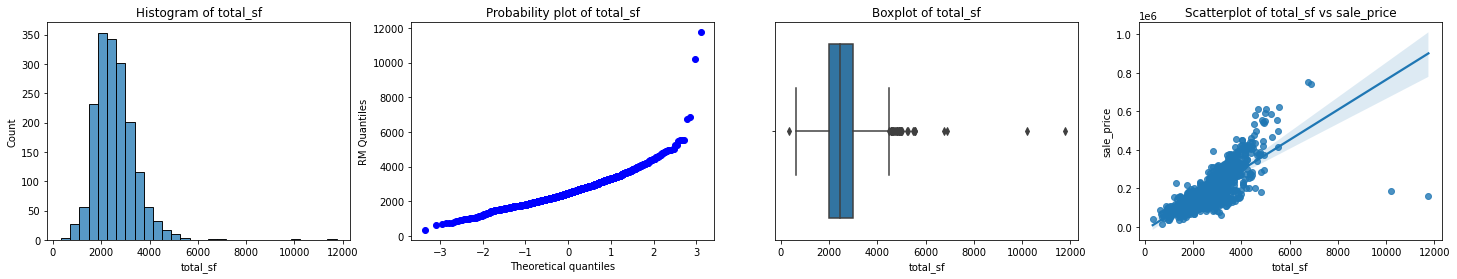

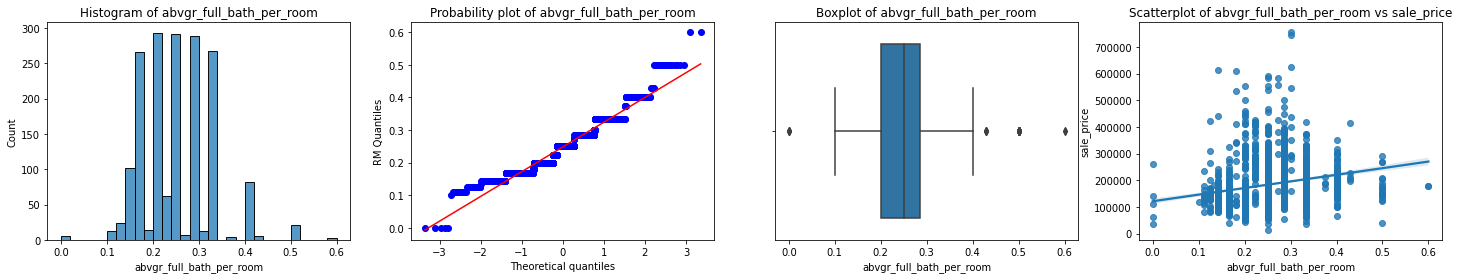

In [35]:
# distributions and probability plots for numeric features

num_features_to_explore = num_df\
  .drop(['bsmt_full_bath', 'full_bath', 'bedroom_abvgr', 'fireplaces', 'totrms_abvgrd', 'kitchen_abvgr'], axis=1)\
  .select_dtypes(exclude='object')

for feature in num_features_to_explore.columns.tolist():
    diagnostic_plots(num_features_to_explore, feature);

__Observation:__ Some numeric featues are heavily skewed. I'll explore using a Yeo-Johnshon transformation as well as cap outliers for a better model.

#### Yeo-Johnson Transformation

In [36]:
# update pipelines

# transform numeric features with yeo-johnson
num_pipe_2 = Pipeline([
    ('num_imputer', SimpleImputer(strategy='median')),
    ('power_trans', PowerTransformer(method='yeo-johnson', standardize=True)) # yeo-johnson transformer
 
])

# full transformation pipeline
full_pipe_2 = ColumnTransformer([
    ('num', num_pipe_2, num_feature_names),
    ('cat', cat_pipe, cat_feature_names),
])

In [37]:
# see the effect of yeo-johnson transformation

# fit full pipeline to train data
full_pipe.fit(X_train)

# transform train and test data
X_train_trans_yj = full_pipe.transform(X_train)

/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable land_slope is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable exter_qual is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable bsmt_exposure is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable central_air is

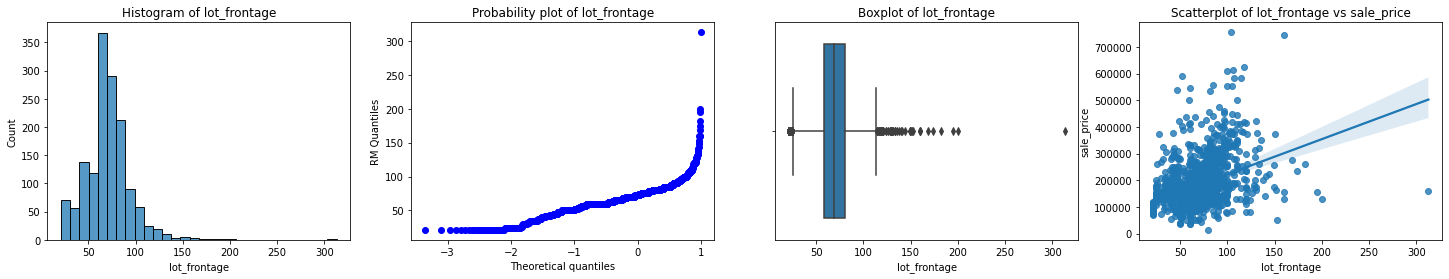

In [38]:
# before yeo-johnson transformation
diagnostic_plots(X_train, 'lot_frontage')

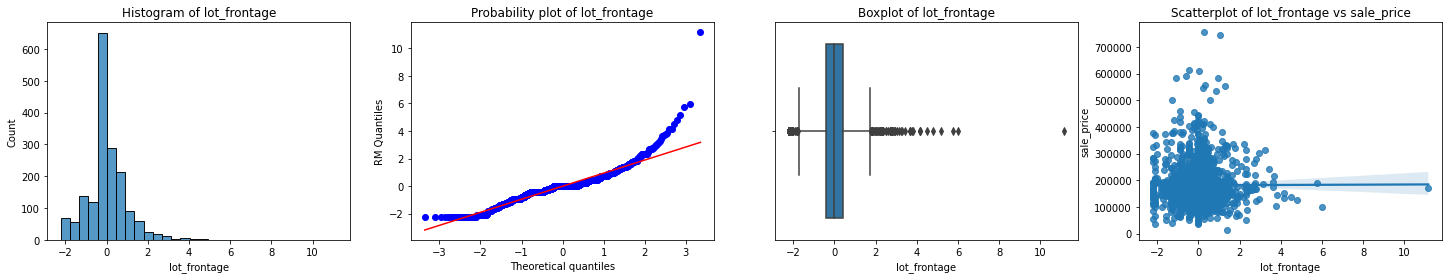

In [39]:
# after yeo-johnson transformation
diagnostic_plots(pd.DataFrame(X_train_trans_yj, columns=trans_feature_names), 'lot_frontage')

In [40]:
# model performance - basic preprocessing & yeo-johnson transformation
get_baseline_model( 
    estimator=RandomForestRegressor(n_estimators=200, max_depth=4, random_state=100),
    preprocessor=full_pipe_2,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    preproc_method='Basic Preprocessing & Yeo_Johnson Transformation'
)

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable land_slope is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable exter_qual is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable bsmt_exposure is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/lo

Preprocessing Method:  Basic Preprocessing & Yeo_Johnson Transformation
------------------------------------------------
Train Set RMSE:  32545.280456502525
Test Set: RMSE 32956.09602642551


__Observation:__ The model looks slightly worse than the baseline. It appears the Yeo-Johnson transformation of numerical features did not help. Next I'll cap the outliers and see if this improves the model performance.

#### Outlier Capping

In [41]:
# imports
from feature_engine.outliers import Winsorizer

In [42]:
# get list of features with outliers
outlier_features = ['lot_frontage', 'lot_area', 'mas_vnr_area', 'bsmtfin_sf_1', 'bsmt_unf_sf', 'gr_liv_area', 'screen_porch', '1st_flr_sf']

In [43]:
# update pipelines

# update pipeline with outlier cap
num_pipe_3 = Pipeline([
    ('num_imputer', MeanMedianImputer(imputation_method='median')), # using feature engine to preserve the pandas dataframe
    ('outlier_cap', Winsorizer(capping_method='quantiles', tail='both', fold=0.025, variables=outlier_features)), # using feature engine to preserve the pandas dataframe
    ('power_trans', PowerTransformer(method='yeo-johnson', standardize=True))
        
])

# preprocess categoricial features
cat_pipe = Pipeline([
    ('cat_imputer', CategoricalImputer(imputation_method='frequent')),
    ('rare_label_enc', RareLabelEncoder(tol=0.05, n_categories=4)),
    ('ohe_enc', OneHotEncoder(handle_unknown='ignore'))
])

# full transformation pipeline
full_pipe_3 = ColumnTransformer([
    ('num', num_pipe_3, num_feature_names),
    ('cat', cat_pipe, cat_feature_names),
])

full_pipe_3

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  MeanMedianImputer()),
                                                 ('outlier_cap',
                                                  Winsorizer(capping_method='quantiles',
                                                             fold=0.025,
                                                             tail='both',
                                                             variables=['lot_frontage',
                                                                        'lot_area',
                                                                        'mas_vnr_area',
                                                                        'bsmtfin_sf_1',
                                                                        'bsmt_unf_sf',
                                                                        'gr_liv_area',
                                                                        'screen_porch',
                                                                        '1st_flr_sf'])),
                                                 ('power_trans',
                                                  PowerTransformer())]),
                                 ['lot_frontage', 'lot...
                                 Pipeline(steps=[('cat_imputer',
                                                  CategoricalImputer(imputation_method='frequent')),
                                                 ('rare_label_enc',
                                                  RareLabelEncoder(n_categories=4)),
                                                 ('ohe_enc',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['ms_zoning', 'land_slope', 'neighborhood',
                                  'roof_matl', 'exterior_1st', 'exter_qual',
                                  'bsmt_qual', 'bsmt_exposure', 'central_air',
                                  'kitchen_qual', 'garage_type',
                                  'garage_finish'])])

In [44]:
# model performance - basic preprocessing & yeo-johnson transformation & outlier capping
get_baseline_model( 
    estimator=RandomForestRegressor(n_estimators=200, max_depth=4, random_state=42),
    preprocessor=full_pipe_3,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    preproc_method='Basic Preprocessing & Yeo_Johnson Transformation & outlier capping'
)

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable land_slope is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable exter_qual is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable bsmt_exposure is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/lo

Preprocessing Method:  Basic Preprocessing & Yeo_Johnson Transformation & outlier capping
------------------------------------------------
Train Set RMSE:  32741.408917549237
Test Set: RMSE 32642.44161935819


__Observation:__ There is a slight improvement after capping outliers.

## Hyperparameter Tuning

In [45]:
# function to evaluate model performance
def get_tuned_model_performance(tune_grid, model_name):
    
    train_score = round(np.sqrt(abs(tune_grid.score(X_train, y_train))), 4)
    test_score = round(np.sqrt(abs(tune_grid.score(X_test, y_test))), 4)
            
    print('Model: ', model_name)
    print('------------------------------------------------')
    print('Train Set RMSE: ', train_score)
    print('Test Set: RMSE', test_score)


#===============================================================================


# function to plot model performance
def get_model_results_plot(model, model_name):

  # predictions
  train_pred = model.predict(X_train)
  test_pred = model.predict(X_test)

  # figure size
  plt.figure(figsize=(14, 4.8))
  
  # actuals
  plt.subplot(1, 2, 1)
  plt.scatter(train_pred, y_train, c='lightblue', label='Train Data', alpha=0.7)
  plt.scatter(test_pred, y_test, c='orange', label='Test Data', alpha=0.7)
  plt.title(model_name + " (Real Values)")
  plt.xlabel("Predicted values")
  plt.ylabel("Real Values")
  plt.legend(loc = "upper left")
  plt.plot([600000, 0], [600000, 0], c = "red")

  # residuals
  plt.subplot(1, 2, 2)
  plt.scatter(y_train, y_train - train_pred, c='lightblue', label='Train Data', alpha=0.7)
  plt.scatter(y_test, y_test - test_pred, c='orange', label='Test Data', alpha=0.7)
  plt.title(model_name + " (Residuals)")
  plt.xlabel("Residuals")
  plt.ylabel("Residuals")
  plt.legend(loc = "upper left")
  plt.hlines(y = 0, xmin = 10000, xmax = 700000, color = "red")

### Ridge Regression

In [42]:
# imports 
from sklearn.linear_model import Ridge

In [43]:
# pipeline
ridge_tune_pipe = Pipeline([ ('preprocessor', full_pipe_3), ('estimator', Ridge(alpha=0.1)) ])

In [44]:
# params
alphas=stats.uniform(0, 60)

# param grid
ridge_param_grid = {'estimator__alpha': alphas}

# set up randomized search
ridge_randomized_search = RandomizedSearchCV( 
    estimator = ridge_tune_pipe,
    param_distributions = ridge_param_grid,
    cv = 5,
    scoring = 'neg_mean_squared_error',
    n_iter = 100, 
    n_jobs = -1,
    random_state = 50,
    refit = True
)

# fit
ridge_randomized_search.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable land_slope is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable exter_qual is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable bsmt_exposure is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/lo

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('num_imputer',
                                                                                                MeanMedianImputer()),
                                                                                               ('outlier_cap',
                                                                                                Winsorizer(capping_method='quantiles',
                                                                                                           fold=0.025,
                                                                                                           tail='both',
                                                                                                           variables=['lot_frontage',
                                                                                                                      'lot_area',
                                                                                                                      'mas_vnr_area',
                                                                                                                      'bsmtfin_sf_1',
                                                                                                                      'bsmt_unf_sf',
                                                                                                                      'gr_liv_area',
                                                                                                                      'screen_porch',
                                                                                                                      '1st_fl...
                                                                                'neighborhood',
                                                                                'roof_matl',
                                                                                'exterior_1st',
                                                                                'exter_qual',
                                                                                'bsmt_qual',
                                                                                'bsmt_exposure',
                                                                                'central_air',
                                                                                'kitchen_qual',
                                                                                'garage_type',
                                                                                'garage_finish'])])),
                                             ('estimator', Ridge(alpha=0.1))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'estimator__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6d6a25b90>},
                   random_state=50, scoring='neg_mean_squared_error')

In [45]:
# get model performance
get_tuned_model_performance(ridge_randomized_search, 'Ridge Regression - Randomized Search CV')

Model:  Ridge Regression - Randomized Search CV
------------------------------------------------
Train Set RMSE:  30568.9875
Test Set: RMSE 30102.397


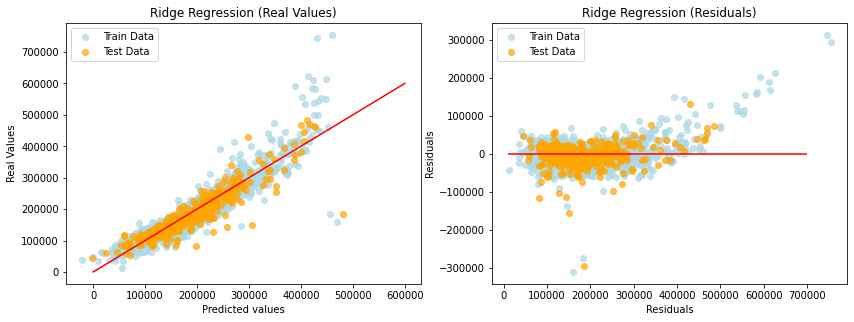

In [46]:
# plot predictions & residuals
get_model_results_plot(model=ridge_randomized_search, model_name="Ridge Regression")

### Lasso Regression

In [47]:
# import
from sklearn.linear_model import Lasso

In [48]:
# pipeline
lasso_tune_pipe = Pipeline([ ('preprocessor', full_pipe_3), ('estimator', Lasso(alpha=1.0)) ])

In [49]:
# params
alphas = stats.uniform(0, 100)

# param grid
lasso_param_grid = {'estimator__alpha': alphas}

# set up randomized search
lasso_randomized_search = RandomizedSearchCV( 
    estimator = lasso_tune_pipe,
    param_distributions = lasso_param_grid,
    cv = 5,
    scoring = 'neg_mean_squared_error',
    n_iter = 100, 
    n_jobs = -1,
    random_state = 50,
    refit = True
)

#fit
lasso_randomized_search.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable land_slope is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable exter_qual is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable bsmt_exposure is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/lo

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('num_imputer',
                                                                                                MeanMedianImputer()),
                                                                                               ('outlier_cap',
                                                                                                Winsorizer(capping_method='quantiles',
                                                                                                           fold=0.025,
                                                                                                           tail='both',
                                                                                                           variables=['lot_frontage',
                                                                                                                      'lot_area',
                                                                                                                      'mas_vnr_area',
                                                                                                                      'bsmtfin_sf_1',
                                                                                                                      'bsmt_unf_sf',
                                                                                                                      'gr_liv_area',
                                                                                                                      'screen_porch',
                                                                                                                      '1st_fl...
                                                                                'neighborhood',
                                                                                'roof_matl',
                                                                                'exterior_1st',
                                                                                'exter_qual',
                                                                                'bsmt_qual',
                                                                                'bsmt_exposure',
                                                                                'central_air',
                                                                                'kitchen_qual',
                                                                                'garage_type',
                                                                                'garage_finish'])])),
                                             ('estimator', Lasso())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'estimator__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6d38d1f50>},
                   random_state=50, scoring='neg_mean_squared_error')

In [50]:
# view best parms
lasso_randomized_search.best_params_

{'estimator__alpha': 92.80009278165524}

In [51]:
# get model performance
get_tuned_model_performance(lasso_randomized_search, 'Lasso Regression - Randomized Search CV')

Model:  Lasso Regression - Randomized Search CV
------------------------------------------------
Train Set RMSE:  30413.7737
Test Set: RMSE 30170.45


### Random Forest

In [47]:
# pipeline
rf_tune_pipe = Pipeline([
    ('preprocessor', full_pipe_3),
    ('estimator', RandomForestRegressor(random_state=101))
])

In [48]:
# params
n_estimators = stats.randint(100, 500)
max_depth = stats.randint(1, 10)
min_samples_split = stats.uniform(0, 1)
max_features = ['sqrt', 'log2']
bootstrap = [True, False]

# param grid
rf_param_grid = {
    'preprocessor__num__outlier_cap__fold':[0.01, 0.025, 0.05],
    #'preprocessor__cat__rare_label_enc__tol':[0.05, 0.07, 0.10],
    'estimator__n_estimators':n_estimators,
    'estimator__max_depth':max_depth,
    'estimator__min_samples_split':min_samples_split,
    'estimator__max_features':max_features,
    'estimator__bootstrap':bootstrap
}

# set up random search
rf_randomized_search = RandomizedSearchCV(
    estimator           = rf_tune_pipe,
    param_distributions = rf_param_grid,
    cv                  = 5,
    scoring             = 'neg_mean_squared_error',
    n_iter              = 100,
    n_jobs              = -1,
    random_state        = 50,
    refit               = True
)

In [49]:
# fit to train data
rf_randomized_search.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable land_slope is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable exter_qual is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable bsmt_exposure is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/lo

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('num_imputer',
                                                                                                MeanMedianImputer()),
                                                                                               ('outlier_cap',
                                                                                                Winsorizer(capping_method='quantiles',
                                                                                                           fold=0.025,
                                                                                                           tail='both',
                                                                                                           variables=['lot_frontage',
                                                                                                                      'lot_area',
                                                                                                                      'mas_vnr_area',
                                                                                                                      'bsmtfin_sf_1',
                                                                                                                      'bsmt_unf_sf',
                                                                                                                      'gr_liv_area',
                                                                                                                      'screen_porch',
                                                                                                                      '1st_fl...
                                        'estimator__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7efdc32b28d0>,
                                        'estimator__max_features': ['sqrt',
                                                                    'log2'],
                                        'estimator__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7efdc32b2350>,
                                        'estimator__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7efdc32b2410>,
                                        'preprocessor__num__outlier_cap__fold': [0.01,
                                                                                 0.025,
                                                                                 0.05]},
                   random_state=50, scoring='neg_mean_squared_error')

In [50]:
# view best params
rf_randomized_search.best_params_

{'estimator__bootstrap': False,
 'estimator__max_depth': 6,
 'estimator__max_features': 'sqrt',
 'estimator__min_samples_split': 0.014415049936586044,
 'estimator__n_estimators': 173,
 'preprocessor__num__outlier_cap__fold': 0.01}

In [51]:
get_tuned_model_performance(rf_randomized_search, 'Random Forest - Randomized Search CV')

Model:  Random Forest - Randomized Search CV
------------------------------------------------
Train Set RMSE:  23400.3413
Test Set: RMSE 27938.1428


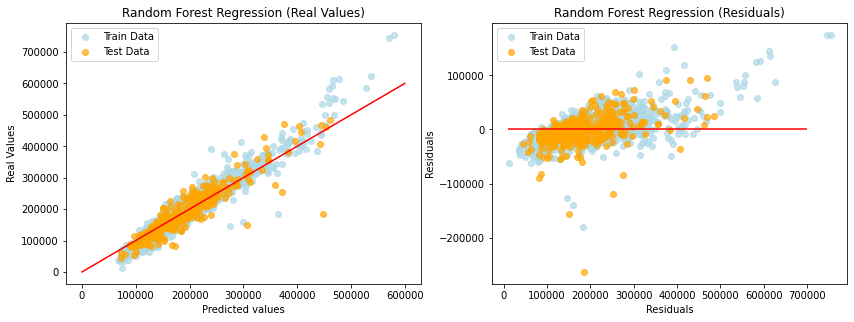

In [139]:
# plot predictions & residuals
get_model_results_plot(model=rf_randomized_search, model_name="Random Forest Regression")

### XGBOOST

In [58]:
# import
import xgboost as xgb

In [140]:
# pipeline
xgb_tune_pipe = Pipeline([
    ('preprocessor', full_pipe_3),
    ('estimator', xgb.XGBRegressor(random_state=101))
])

In [141]:
# params
n_estimators = stats.randint(100, 500)
max_depth = stats.randint(1, 10)
learning_rate = stats.uniform(0, 1)
gamma = stats.uniform(0, 1)
reg_alpha = stats.randint(0, 20)
scale_pos_weight = stats.randint(1, 5)
subsample = [0.9, 0.93, 0.95]
colsample_bytree = [0.8, 0.85, 0.9]

# param grid
xgb_param_grid = {
    'preprocessor__num__outlier_cap__fold':[0.01, 0.025, 0.05],
    #'preprocessor__cat__rare_label_enc__tol':[0.05, 0.07, 0.10],
    'estimator__n_estimators':n_estimators,
    'estimator__max_depth':max_depth,
    'estimator__learning_rate':learning_rate,
    'estimator__gamma':gamma,
    'estimator__reg_alpha':reg_alpha,
    'estimator__scale_pos_weight':scale_pos_weight,
    'estimator__subsample':subsample,
    'estimator__colsample_bytree':colsample_bytree
}

# set up random search
xgb_randomized_search = RandomizedSearchCV(
    estimator           = xgb_tune_pipe,
    param_distributions = xgb_param_grid,
    cv                  = 5,
    scoring             = 'neg_mean_squared_error',
    n_iter              = 200,
    n_jobs              = -1,
    random_state        = 60,
    refit               = True
)


In [142]:
# fit to train data
xgb_randomized_search.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable land_slope is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable exter_qual is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable bsmt_exposure is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/lo

[00:28:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('num_imputer',
                                                                                                MeanMedianImputer()),
                                                                                               ('outlier_cap',
                                                                                                Winsorizer(capping_method='quantiles',
                                                                                                           fold=0.025,
                                                                                                           tail='both',
                                                                                                           variables=['lot_frontage',
                                                                                                                      'lot_area',
                                                                                                                      'mas_vnr_area',
                                                                                                                      'bsmtfin_sf_1',
                                                                                                                      'bsmt_unf_sf',
                                                                                                                      'gr_liv_area',
                                                                                                                      'screen_porch',
                                                                                                                      '1st_fl...
                                        'estimator__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6d9247450>,
                                        'estimator__reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6d9247dd0>,
                                        'estimator__scale_pos_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6d9247390>,
                                        'estimator__subsample': [0.9, 0.93,
                                                                 0.95],
                                        'preprocessor__num__outlier_cap__fold': [0.01,
                                                                                 0.025,
                                                                                 0.05]},
                   random_state=60, scoring='neg_mean_squared_error')

In [143]:
# best params
xgb_randomized_search.best_params_

{'estimator__colsample_bytree': 0.8,
 'estimator__gamma': 0.341879364550151,
 'estimator__learning_rate': 0.0698686716360164,
 'estimator__max_depth': 5,
 'estimator__n_estimators': 336,
 'estimator__reg_alpha': 18,
 'estimator__scale_pos_weight': 3,
 'estimator__subsample': 0.95,
 'preprocessor__num__outlier_cap__fold': 0.05}

In [144]:
# model performance
get_tuned_model_performance(xgb_randomized_search, 'Xgboost - Randomized Search CV')

Model:  Xgboost - Randomized Search CV
------------------------------------------------
Train Set RMSE:  4827.8923
Test Set: RMSE 27749.7587


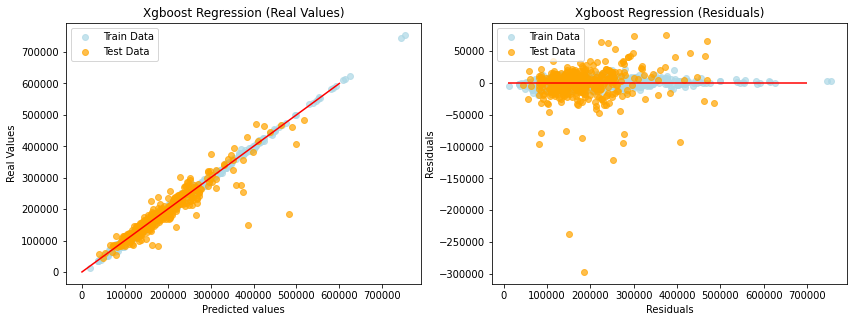

In [145]:
# plot predictions & residuals
get_model_results_plot(model=xgb_randomized_search, model_name="Xgboost Regression")

#### Plot Xgboost Hyperparameters vs Error Metric

In [146]:
# randomized search dataframe 
cv_res_df = pd.DataFrame(xgb_randomized_search.cv_results_)

# get list of columns we are interested in
col_list = ["mean_test_score", "std_test_score", "rank_test_score"] + [col for col in cv_res_df.columns if col.startswith("param_")]

# sort by mean_test_score
cv_res_df = cv_res_df[col_list]\
   .sort_values(by="mean_test_score", ascending=True)\
   .assign(mean_test_score = lambda x: -x['mean_test_score'])\
   .reset_index()\
   .rename(columns = lambda x: x.replace("param_estimator__", ""))\
   .rename(columns = lambda x: x.replace("param_processor__", ""))

cv_res_df.head()

,index,mean_test_score,std_test_score,rank_test_score,colsample_bytree,gamma,learning_rate,max_depth,n_estimators,reg_alpha,scale_pos_weight,subsample,param_preprocessor__num__outlier_cap__fold
0,121,1.867556e+09,1.355273e+08,200,0.8,0.523393,0.005109,3,376,17,3,0.95,0.025
1,125,1.402707e+09,2.595657e+08,199,0.9,0.315266,0.979374,4,408,11,3,0.93,0.025
2,134,1.401576e+09,3.499625e+07,198,0.9,0.495124,0.956102,8,294,2,3,0.9,0.01
3,8,1.354915e+09,1.462836e+08,197,0.9,0.84512,0.933202,9,372,7,3,0.93,0.01
4,53,1.354713e+09,4.667772e+07,196,0.9,0.603217,0.989434,8,115,10,3,0.95,0.01


In [147]:
# function to plot randomized search
def cv_plot(data, x, y, subplot):
  plt.scatter(data=cv_res_df, x=x, y=y);
  plt.xlabel(x)
  plt.ylabel(y)
  plt.title('{} vs {}'.format(x, y))

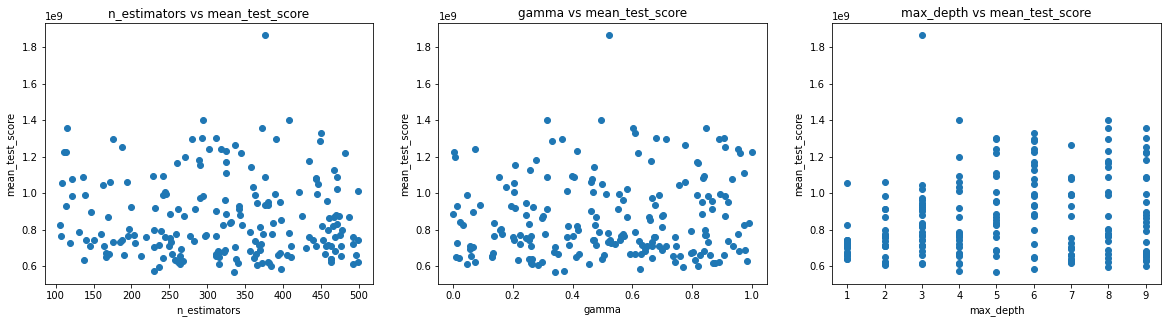

In [148]:
# plot key hyperparameters
plt.figure(figsize=(20, 4.8))

cv_plot(cv_res_df, 'n_estimators', 'mean_test_score', plt.subplot(1, 3, 1))
cv_plot(cv_res_df, 'gamma', 'mean_test_score', plt.subplot(1, 3, 2))
cv_plot(cv_res_df, 'max_depth', 'mean_test_score', plt.subplot(1, 3, 3))

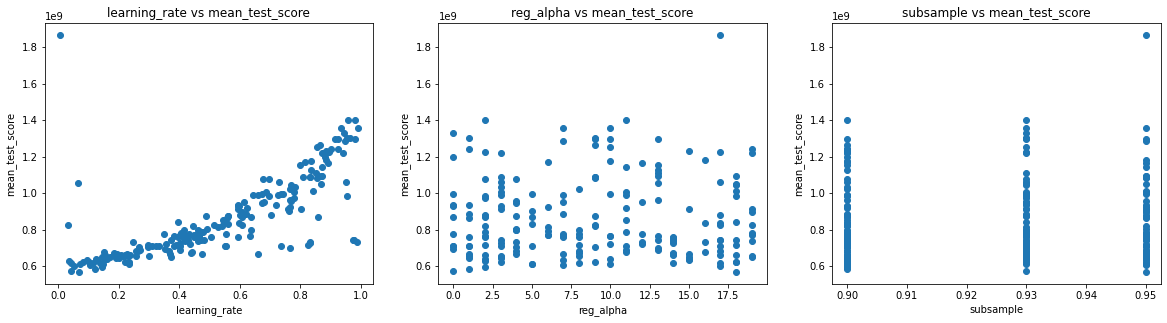

In [149]:
# plot key hyperparameters
plt.figure(figsize=(20, 4.8))

cv_plot(cv_res_df, 'learning_rate', 'mean_test_score', plt.subplot(1, 3, 1))
cv_plot(cv_res_df, 'reg_alpha', 'mean_test_score', plt.subplot(1, 3, 2))
cv_plot(cv_res_df, 'subsample', 'mean_test_score', plt.subplot(1, 3, 3))

#### Xgboost Using Adjusted Param Grid Retrain Model

In [153]:
# import 
from sklearn.model_selection import GridSearchCV

In [163]:
# update param grid
n_estimators = [336, 337, 338]
max_depth = [5]
learning_rate = [0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14]
gamma = [0.341879364550151]
reg_alpha = [18]
scale_pos_weight = [3]
subsample = [0.95]
colsample_bytree = [0.8]

# param grid
xgb_param_grid_2 = {
    # preprocessor__num__outlier_cap__fold':[0.01, 0.025, 0.05],
    #'preprocessor__cat__rare_label_enc__tol':[0.05, 0.07, 0.10],
    'estimator__n_estimators':n_estimators,
    'estimator__max_depth':max_depth,
    'estimator__learning_rate':learning_rate,
    'estimator__gamma':gamma,
    'estimator__reg_alpha':reg_alpha,
    'estimator__scale_pos_weight':scale_pos_weight,
    'estimator__subsample':subsample,
    'estimator__colsample_bytree':colsample_bytree
}

# set up random search
xgb_grid_search = GridSearchCV(
    estimator           = xgb_tune_pipe,
    param_grid          = xgb_param_grid_2,
    cv                  = 5,
    scoring             = 'neg_mean_squared_error',
    n_jobs              = -1,
    refit               = True
)


In [164]:
# fit to train data
xgb_grid_search.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable land_slope is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable exter_qual is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:177: UserWarning: The number of unique categories for variable bsmt_exposure is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "considered frequent".format(var)
/usr/lo

[01:01:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          MeanMedianImputer()),
                                                                                         ('outlier_cap',
                                                                                          Winsorizer(capping_method='quantiles',
                                                                                                     fold=0.025,
                                                                                                     tail='both',
                                                                                                     variables=['lot_frontage',
                                                                                                                'lot_area',
                                                                                                                'mas_vnr_area',
                                                                                                                'bsmtfin_sf_1',
                                                                                                                'bsmt_unf_sf',
                                                                                                                'gr_liv_area',
                                                                                                                'screen_porch',
                                                                                                                '1st_flr_sf']...
             n_jobs=-1,
             param_grid={'estimator__colsample_bytree': [0.8],
                         'estimator__gamma': [0.341879364550151],
                         'estimator__learning_rate': [0.0, 0.02, 0.04, 0.06,
                                                      0.08, 0.1, 0.12, 0.14],
                         'estimator__max_depth': [5],
                         'estimator__n_estimators': [336, 337, 338],
                         'estimator__reg_alpha': [18],
                         'estimator__scale_pos_weight': [3],
                         'estimator__subsample': [0.95]},
             scoring='neg_mean_squared_error')

In [165]:
# best params
xgb_grid_search.best_params_

{'estimator__colsample_bytree': 0.8,
 'estimator__gamma': 0.341879364550151,
 'estimator__learning_rate': 0.04,
 'estimator__max_depth': 5,
 'estimator__n_estimators': 338,
 'estimator__reg_alpha': 18,
 'estimator__scale_pos_weight': 3,
 'estimator__subsample': 0.95}

In [166]:
# model performance
get_tuned_model_performance(xgb_grid_search, 'Xgboost - Grid Search CV')

Model:  Xgboost - Grid Search CV
------------------------------------------------
Train Set RMSE:  7835.7876
Test Set: RMSE 27253.1244


## Feature Importance

In [167]:
# feature importance values
feature_importance = xgb_grid_search.best_estimator_.named_steps['estimator'].feature_importances_

In [112]:
# feature names
feature_names = num_feature_names + full_pipe.named_transformers_['cat']['ohe_enc'].get_feature_names_out().tolist()

In [180]:
feature_importance = pd.Series(feature_importance, feature_names)
feature_importance.sort_values(inplace=True)

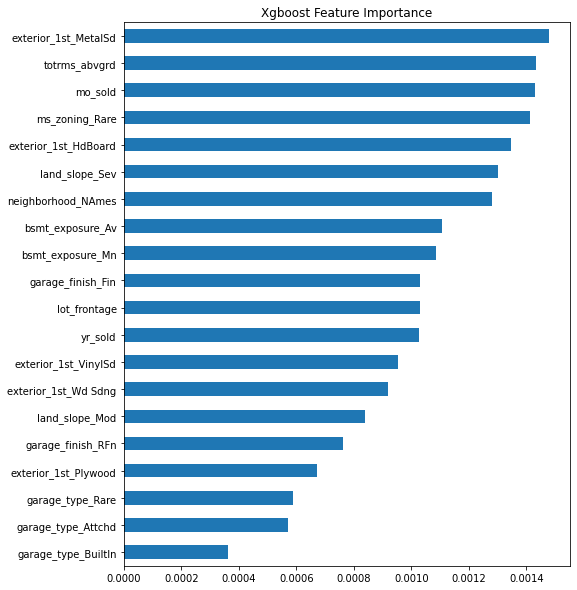

In [189]:
# visualize feature importance
plt.figure(figsize = (8, 10))
feature_importance.iloc[0:20].plot.barh();
plt.title("Xgboost Feature Importance");